In [50]:
import zipfile
import os

def unarchive_zip(zip_file_path, output_dir):
    """Unarchive a .zip file."""
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Unarchived {zip_file_path} to {output_dir}")

# Example usage
zip_file_path = '/home/ec2-user/SageMaker/Archive.zip'  # Replace with your actual .zip file path
output_dir = '/home/ec2-user/SageMaker/brain_tumor_data/'  # Replace with your output directory
unarchive_zip(zip_file_path, output_dir)


Unarchived /home/ec2-user/SageMaker/Archive.zip to /home/ec2-user/SageMaker/brain_tumor_data/


In [52]:
import os

def delete_ds_store_files(directory):
    """Delete all .DS_Store files in the given directory."""
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Example usage:
delete_ds_store_files(train_dir)  # Delete .DS_Store files from the train directory
delete_ds_store_files(test_dir)   # Delete .DS_Store files from the test directory


In [53]:
import pandas as pd

# Function to extract label from filename
def extract_label(filename):
    if "Tr-gl" in filename or "Te-gl" in filename:
        return "Yes"
    elif "Tr-no" in filename or "Te-no" in filename:
        return "No"

# Get all train and test images
train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)

# Create DataFrames
train_df = pd.DataFrame({"filename": train_images})
test_df = pd.DataFrame({"filename": test_images})

# Assign labels
train_df["label"] = train_df["filename"].apply(extract_label)
test_df["label"] = test_df["filename"].apply(extract_label)

# Save CSV files
train_csv_path = os.path.join(local_folder, "train_labels.csv")
test_csv_path = os.path.join(local_folder, "test_labels.csv")

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"CSV files created: {train_csv_path}, {test_csv_path}")


CSV files created: /home/ec2-user/SageMaker/brain_tumor_data/train_labels.csv, /home/ec2-user/SageMaker/brain_tumor_data/test_labels.csv


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
image_size = (224, 224)
batch_size = 16

# Read the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Ensure labels are strings
train_df["label"] = train_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load training and validation data
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

# Load test data
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col="filename",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Data generators ready!")


Found 2333 validated image filenames belonging to 2 classes.
Found 583 validated image filenames belonging to 2 classes.
Found 705 validated image filenames belonging to 2 classes.
Data generators ready!


## Train EfficientNetB0

In [55]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Custom classifier head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

print("Model training completed!")


2025-03-02 20:19:07.138401: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10


2025-03-02 20:19:54.730228: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-02 20:19:56.201861: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-02 20:19:56.228801: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-02 20:19:56.261884: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-03-02 20:19:56.281814: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.


146/146 [==============================] - 256s 1s/step - loss: 0.6986 - accuracy: 0.5379 - val_loss: 0.6889 - val_accuracy: 0.5455
Epoch 2/10
146/146 [==============================] - 199s 1s/step - loss: 0.6892 - accuracy: 0.5491 - val_loss: 0.6880 - val_accuracy: 0.5455
Epoch 3/10
146/146 [==============================] - 191s 1s/step - loss: 0.6884 - accuracy: 0.5474 - val_loss: 0.6864 - val_accuracy: 0.5455
Epoch 4/10
146/146 [==============================] - 188s 1s/step - loss: 0.6894 - accuracy: 0.5474 - val_loss: 0.6858 - val_accuracy: 0.5455
Epoch 5/10
146/146 [==============================] - 195s 1s/step - loss: 0.6862 - accuracy: 0.5474 - val_loss: 0.6848 - val_accuracy: 0.5455
Epoch 6/10
146/146 [==============================] - 193s 1s/step - loss: 0.6859 - accuracy: 0.5474 - val_loss: 0.6817 - val_accuracy: 0.5455
Epoch 7/10
146/146 [==============================] - 183s 1s/step - loss: 0.6838 - accuracy: 0.5474 - val_loss: 0.6819 - val_accuracy: 0.5455
Epoch 8/10

In [57]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

45/45 [==============================] - 42s 922ms/step - loss: 0.6694 - accuracy: 0.5745
Test Accuracy: 0.5745


In [58]:
# Save model locally
model.save("/home/ec2-user/SageMaker/brain_tumor_model.h5")
print("Model saved successfully!")

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


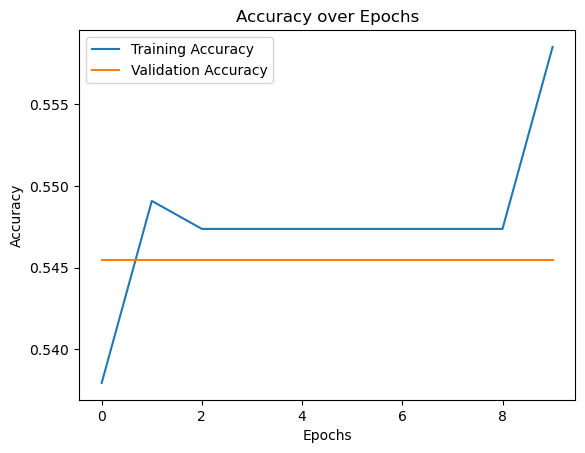

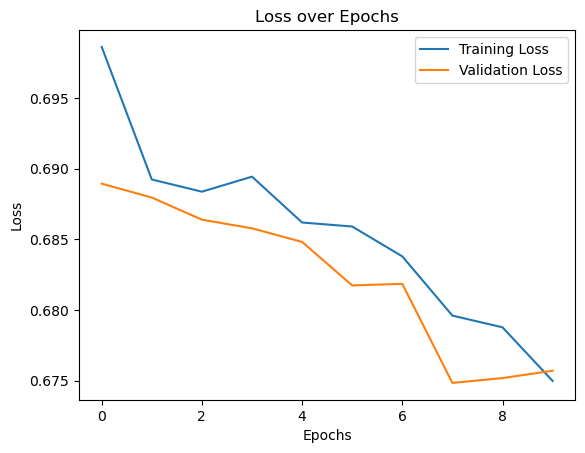

45/45 [==============================] - 44s 983ms/step
Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.57      1.00      0.73       405
       Tumor       0.00      0.00      0.00       300

    accuracy                           0.57       705
   macro avg       0.29      0.50      0.36       705
weighted avg       0.33      0.57      0.42       705



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

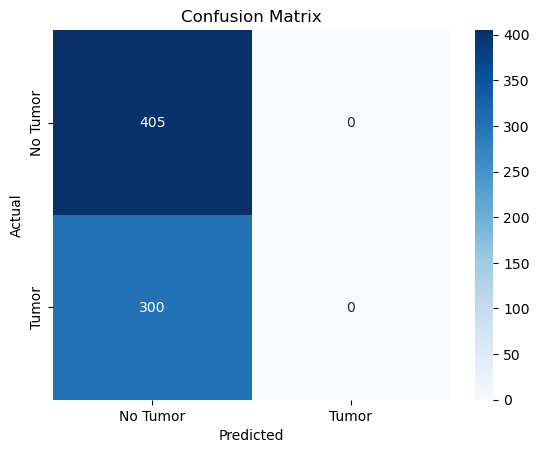

In [63]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Predict on the test data and evaluate performance
y_true = test_generator.classes  # Ground truth labels
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 101ms/step


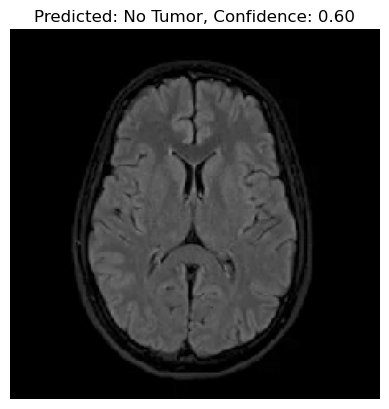

In [65]:
# Prediction and visualization function
class_labels = ['No Tumor', 'Tumor']

def predict_and_visualize(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))  # Match model's input size (224x224)
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize and add batch dimension

    # Make prediction
    prediction = model.predict(img_array)[0][0]  # Get the predicted probability
    predicted_class = class_labels[int(prediction > 0.5)]  # Determine class based on threshold
    confidence = prediction if prediction > 0.5 else 1 - prediction  # Calculate confidence

    # Display the image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Test on sample images
test_image_paths = [
    '/home/ec2-user/SageMaker/brain_tumor_data/sampleimages/notumor.jpg',
]

for img_path in test_image_paths:
    predict_and_visualize(img_path)


### Business Problem:  
The goal is to leverage deep learning to detect brain tumors from MRI scans, assisting radiologists in early diagnosis and treatment planning, ultimately improving patient outcomes.

### Dataset Overview:  
The dataset consists of MRI images stored in an AWS S3 bucket, with each image labeled as either "tumor-present" (Yes) or "tumor-absent" (No). This labeled data enables the development of a model to accurately classify brain tumors.

### Chosen Model and Rationale:  
We employed **EfficientNet**, a state-of-the-art convolutional neural network (CNN), due to its exceptional accuracy, parameter efficiency, and ability to generalize well, especially for medical image classification tasks. Compared to traditional CNN architectures, EfficientNet has proven to deliver superior performance with fewer resources, making it ideal for medical imaging challenges like brain tumor detection.

### Next Steps:  
- **Model Improvement**: Further enhance the model through techniques like data augmentation, transfer learning, and hyperparameter tuning.
- **Deployment**: Deploy the fine-tuned model for real-time inference using **TensorFlow Serving** or **AWS SageMaker Endpoint** to provide accessible, on-demand predictions.

### Impact and Applications:  
- **Medical Diagnosis**: This model will aid radiologists by automating the analysis of MRI scans, enabling earlier and more accurate brain tumor detection.  
- **Telemedicine**: The solution will also support remote diagnosis, particularly benefiting patients in underserved areas with limited access to medical specialists.
